# Trees & Bagging & Boosting (Linear Regression -- Loan Club Dataset)

To improve our regression model, we can apply powerful ideas like Regression Trees, Bagging, and Boosting. These models can be hard to interpret compared to simple linear regression. However, they can offer a better prediction power.
In this notebook, we used regression trees and apply neccessary pruning to reduce tree complexity using cross validation.
We apply Bagging along with regression trees, as well as random forests to reduce the variance of simple regression trees.
We finally apply Boosting to reduce the corrolation between estimators that arises in case of Bagging.

### Load libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import sklearn

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, explained_variance_score

from IPython.display import Markdown, display

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

# Useful function for Jupyter to display text in bold:
def displaybd(text):
    display(Markdown("**" + text + "**"))

In [2]:
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10

### Helper Functions:

The plot_cv_results function is used to plot the results from cross validation procedure. It takes a CV instance, and plots the assosiated results against the grid of parameters. It also identify the best parameter on the graph.

The plot_features_importance plots the sorted feature importance for tree-based methods as a horizontal bar plot.

In [44]:
def plot_cv_results(gs, param_name, xtitle):
    results = gs.cv_results_
    best_param_val = gs.best_params_[param_name]
    # Get the regular numpy array from the MaskedArray
    x_axis_ticks = np.array(results['param_' + param_name].data, dtype=float)

    fig, ax = plt.subplots()
    ax.plot(x_axis_ticks, -results['mean_test_score'])
    ax.plot(best_param_val, -gs.best_score_,
            marker='x', markersize=10, mew=2)
    ax.fill_between(x_axis_ticks,
                    -results['mean_test_score'] - results['std_test_score'],
                    -results['mean_test_score'] + results['std_test_score'],
                    alpha=0.2)
    ax.set_xlabel(xtitle)
    ax.set_ylabel('CV mean squared error');
    
def plot_features_importance(importance, colsNames):
    #tree_feature_importances = tree.feature_importances_
    sorted_idx = importance.argsort()

    y_ticks = np.arange(0, len(colsNames))
    fig, ax = plt.subplots()
    ax.barh(y_ticks, importance[sorted_idx])
    ax.set_yticklabels(np.array(colsNames)[sorted_idx])
    ax.set_yticks(y_ticks)
    # MDI = Mean Decrease in Impurity
    ax.set_title("Feature Importances on Training Data")
    fig.tight_layout()
    plt.show()

# 1. Data:

## Get and Clean the Data

We use the same data from previous notebooks; however, we select a subset of features that can best predict the desired outcome (total_pymnt). These 6 features were identified from the ridge and lasso coefficients that minimized the MSE out of a total of 52 other features. 

In [3]:
#-- LOAD DATA:

# Load sampled and cleaned loan club dataset
datetime_cols = ['issue_d','last_pymnt_d']
loan_club = pd.read_csv('Loan_sampled_cleaned.csv',parse_dates = datetime_cols)
loan_club_fully_paid = loan_club[loan_club['loan_status']=='Fully Paid'].reset_index(drop=True)
loan_club_fully_paid['loan_period'] = loan_club_fully_paid['last_pymnt_d'] - loan_club_fully_paid['issue_d']
loan_club_fully_paid['loan_period'] = loan_club_fully_paid['loan_period'] / pd.to_timedelta(1, unit='D')

best_subet = ['total_pymnt','loan_amnt','loan_period','int_rate','term','total_rec_int', 'last_pymnt_amnt']
loan_club_fully_paid = loan_club_fully_paid[best_subet]
# Select skewed regressors that should have log transformation. 
colsToLn = list(loan_club_fully_paid.select_dtypes(include=[np.number]).columns)
colsToLn.remove('loan_period')
colsToLn.remove('int_rate')

# Log transform
ln_cols = []
for colName in colsToLn:
    lnColName = "ln_" + colName
    loan_club_fully_paid[lnColName] = np.log(np.exp(1)+loan_club_fully_paid[colName])
    loan_club_fully_paid.drop([colName], axis=1,inplace = True)
    ln_cols.append(lnColName)
# Convert categorical variables into dummies:
dummies = pd.get_dummies(loan_club_fully_paid[['term']])
X = loan_club_fully_paid[ln_cols+['int_rate','loan_period']].drop(['ln_total_pymnt'], axis=1)
cat_features = ['term_ 36 months']

# Extract predictors and outcome variables
X = pd.concat([X, dummies[cat_features]], axis=1)
feature_names = X.columns
y = loan_club_fully_paid.ln_total_pymnt
    
display(X[0:10],y[0:10])

print('Data shape: ', X.shape)

,ln_loan_amnt,ln_total_rec_int,ln_last_pymnt_amnt,int_rate,loan_period,term_ 36 months
0,8.854054,7.384783,7.404394,14.33,911.0,1
1,10.126740,8.318471,9.863729,11.49,577.0,0
2,8.517737,6.043151,5.713661,5.32,1066.0,1
3,10.463181,8.942744,9.347387,14.31,821.0,1
4,8.699968,7.207799,5.355020,13.66,1126.0,1
5,10.126740,7.011285,9.723919,11.55,153.0,1
6,9.998921,7.732829,9.720358,8.18,519.0,0
7,9.451537,6.920996,9.315657,14.49,212.0,1
8,10.463181,9.157058,7.121186,16.29,1127.0,1
9,9.433701,7.504908,6.346002,10.99,943.0,1


0     9.060828
1    10.278455
2     8.598076
3    10.660833
4     8.902444
5    10.170038
6    10.097493
7     9.527945
8    10.702820
9     9.569199
Name: ln_total_pymnt, dtype: float64

Data shape:  (33887, 6)


**The data has 33887 observations with 6 features.** 

## Split the data:

To validate our model performance on generalizing to unknown data, we need to to have some test subset for evaluating our model. We split our data into training and test subsets. Within the training data, we can use some validation subset to perform cross-validation for parameters tuning.  
We split the data into 2/3 for training, and 1/3 for testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print("No. training samples", X_train.shape[0])
print("No. testing samples", X_test.shape[0])

No. training samples 22704
No. testing samples 11183


## 2. Benchmark Linear model:

The best linear model was obtained by applying shrinkage methods like lasso and ridge to the complete set of numerical features. The features used for this notebook are ones with non-zero coefficients for lasso. We use these features to fit a simple linear model that uses log-transformed features. This could serve as a benchmark to compare it with other tree-based and boosting methods.

In [30]:
best_subset_linear = LinearRegression();
best_subset_linear.fit(X_train,y_train);

We can evaluate the model performance on the training set. However, evaluation on the test set is more significant. We keep it for later sections.

In [32]:
y_predicted_train_bestsubset = best_subset_linear.predict(X_train)
print("Best_Subset Train MSE: ",mean_squared_error(y_predicted_train_bestsubset,y_train))
print("Best_Subset Train R2: ", best_subset_linear.score(X_train,y_train))

Best_Subset Train MSE:  0.0007519678876769355
Best_Subset Train R2:  0.998507019773442


The benchmark model seems to be doing quite good. These results can be satisfactory; however, tree based methods can maybe do better.

Let's identify the most importance features from 

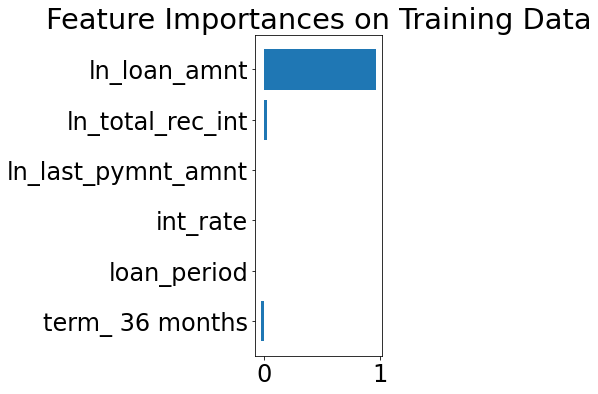

In [45]:
coeffs = best_subset_linear.coef_
plot_features_importance(coeffs, xColsNames)

For this linear regression model, ln_loan_amnt is the most significant feature with some contribution from ln_total_rec_int and term features. It is expected for loan_amnt to have a high influence.

# 3. Simple Regression Tree: 

Tree-based methods can be very effective in prediction and classification tasks. A moderately deep tree can be easy to explain by describing the tree splits. However, deep trees are hard to explain and can easily overfit.

One techqnique to avoid overfitting is tree pruning. This can be achieved using cross-validation on the number of max_leaf_nodes or the complexity parameter ccp_alpha.

We use the sklearn [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) to fit our model.

## Cross-validation on the number of leaves
The performance of the tree depends on many parameters that can be tuned. Each can be used to limit the complexity of the tree like the max depth, minumum sample split, or the maximum number of leaves. Here we use cross validation to find the optimum number of leaves. 

In [7]:
# NB: This is a bad way to do cross-validation on a tree:
# We are repeating the same task again and again: tree with (n+1) leaves
# is almost the same as tree with n leaves. But it is OK for our purposes:
# simple regression trees are, anyway, not the best approach.
#
# This is an example of the right implementation of pruning with cross-validation:
# https://matthewmcgonagle.github.io/blog/2018/09/13/PruningDecisionTree

MAX_LEAVES = 1000

kf = KFold(n_splits=10, shuffle=True, random_state=1)
gs_tree_reg_1 = GridSearchCV(DecisionTreeRegressor(),
                             cv=kf,
                             param_grid={'max_leaf_nodes': np.arange(2, MAX_LEAVES+1)},
                             scoring='neg_mean_squared_error',
                             n_jobs=-1, # Use all CPU cores
                             verbose=1,
                             return_train_score=True)
gs_tree_reg_1.fit(X_train, y_train);

Fitting 10 folds for each of 999 candidates, totalling 9990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2744 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 4544 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6744 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 9344 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 9990 out of 9990 | elapsed:  3.7min finished


Optimal number of leaves: 994
Minimum MSE: 0.00013431460093116127


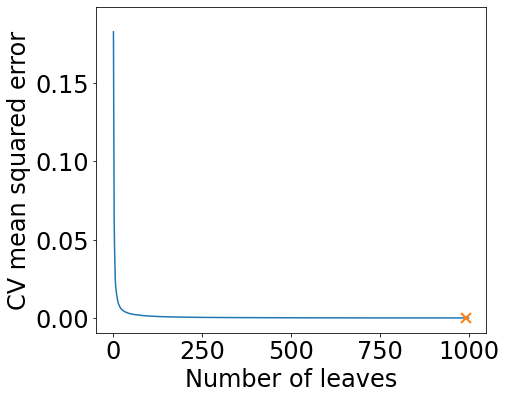

In [57]:
best_n_leaves = gs_tree_reg_1.best_params_['max_leaf_nodes']
print('Optimal number of leaves:', best_n_leaves)
print('Minimum MSE:', -gs_tree_reg_1.best_score_)

plot_cv_results(gs_tree_reg_1, 'max_leaf_nodes', 'Number of leaves')

The optimum number of leaves that minimizes the cross-validation MSE is 994. This is a relatively deep tree but we managed to get an improvement on the MSE for the training set. 

## Cross-validation on the complexity parameter
Complexity paramater can control the tree complexity by limiting the tree complexity to a maximum of ccp_alpha value. We use cross validation to find the optimal tree by varying ccp_alpha. 

In [61]:
# NB: Again, this is a bad way to do cross-validation on a tree.
# Theoretically, cross-validation on the complexity parameter is
# equivalent to doing cross-validation on the number of leaves:
# for each tree with a particular number of leaves, there is
# a complexity parameter that gives this tree. But, practically, we
# loop through a grid for the complexity parameter values, and we
# are skipping trees with some number of leaves, while getting trees with
# a particular number of leaves several times (different values of the
# complexity parameter might give the same tree).

ccp_alphas = np.logspace(-7, -2, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
gs_tree_reg_2 = GridSearchCV(DecisionTreeRegressor(),
                             cv=kf,
                             param_grid={'ccp_alpha': ccp_alphas},
                             scoring='neg_mean_squared_error',
                             n_jobs=-1, # Use all CPU cores
                             verbose=1,
                             return_train_score=True)
gs_tree_reg_2.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.7min finished


Optimal complexity parameter: 1e-07
Number of nodes in the tree: 1955
Number of leaves in the tree: 978
Maximal depth of the tree: 13
Minimum MSE: 0.000136423612151875


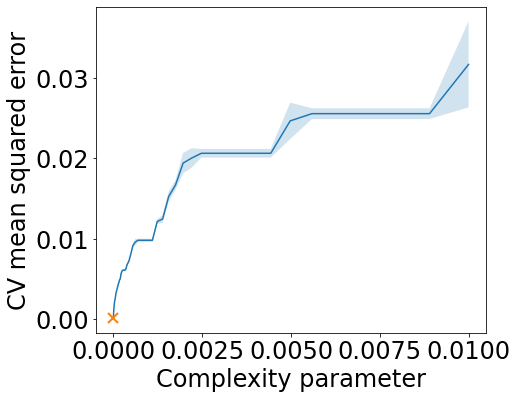

In [71]:
best_reg_tree_alpha = gs_tree_reg_2.best_params_['ccp_alpha']
best_reg_tree = gs_tree_reg_2.best_estimator_

print("Optimal complexity parameter:", best_reg_tree_alpha)
# See help(sklearn.tree._tree.Tree) for the description of attributes of the tree:
print("Number of nodes in the tree:", best_reg_tree.tree_.node_count)
print("Number of leaves in the tree:", best_reg_tree.tree_.n_leaves)
print("Maximal depth of the tree:", best_reg_tree.tree_.max_depth)
print('Minimum MSE:', -gs_tree_reg_2.best_score_)

plot_cv_results(gs_tree_reg_2, 'ccp_alpha', 'Complexity parameter')

The optimal compexity parameter was the lowest value within the specified range (1e-7). The obtained tree is very similiar to the one obtained by performing CV on the maximum number of leaves. Lower cpp_alpha values can get an even better tree.

Let's visualize the tree.

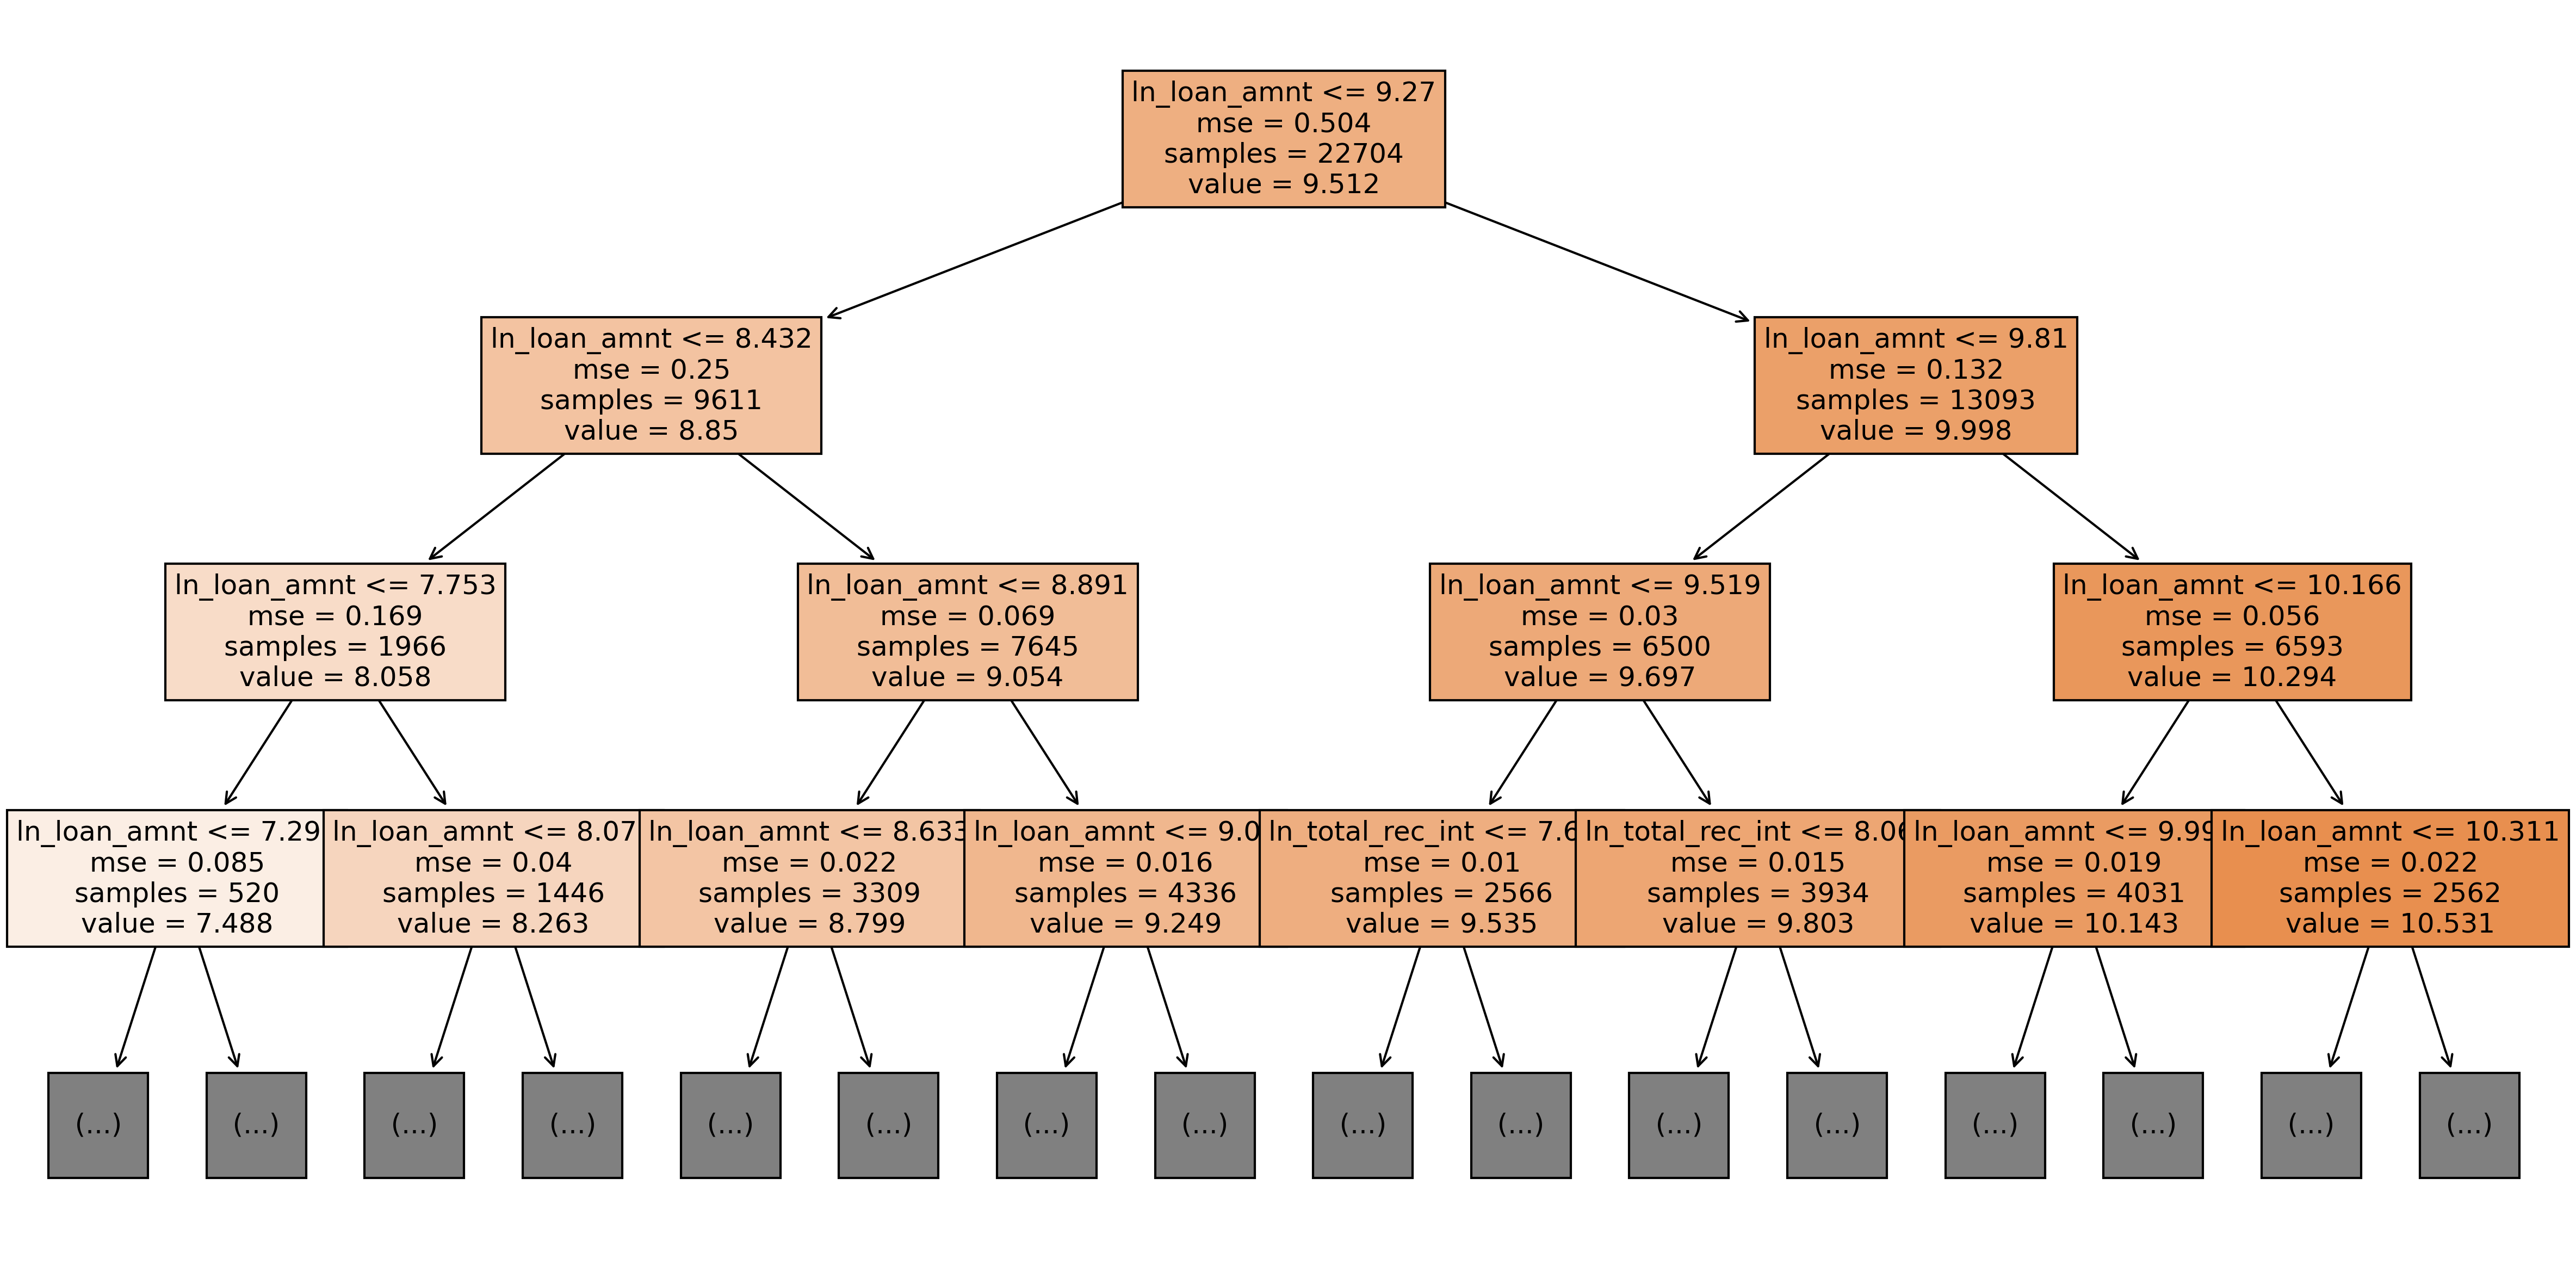

In [63]:
#-- PLOT TREE
xColsNames = X.columns
# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (20, 10), dpi=300)

# Value is the mean value of the outcome variable
plot_tree(best_reg_tree,
          feature_names=xColsNames,
          filled=True,
          max_depth=3,
          fontsize=12
);

The splits are made to minimize the MSE across the split. Most of the splits are done over the ln_loan_amnt. We can also see splits across ln_total_rec_int. This proposes that these features are more important than others. 

Let's plot features importance.

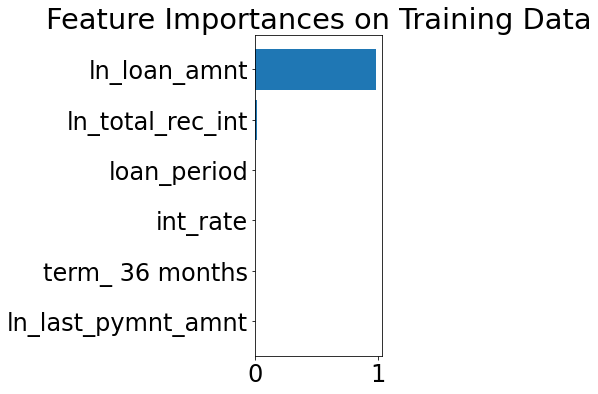

In [64]:
plot_features_importance(best_reg_tree.feature_importances_, xColsNames)

Indeed, ln_loan_amnt is the most significant feature as in the case of linear regression. ln_total_rec_int also have some significance unlike the rest of the features. It is expected that the total_pymnt should have a high dependancy on loan_amnt.

# 4. Random Forest :

Simple regression trees, especially deep ones, can suffer from high variance. Bagging can resolve this issue by combining multiple estimators fitted on subsets of the data. This can reduce the variance and improve the goodness of fit. However, it reduces the interpretablity of the model. Bagging can be performed with any kind of estimator. The out-of-bag score can be directly used to evaluate the goodness of fit without the need of an external validation or test set. The score of oob would be very similiar to the validation score.

We apply bagging over decision tree as follows:. 

In [72]:
# Bagging tree, different from OLS, gives an improvement over a single tree.

n_estimators = 500 # Nmb of regression trees to ensemble
bag_tree_reg = BaggingRegressor(DecisionTreeRegressor(),
                           n_estimators=n_estimators,
                           bootstrap=True,
                           oob_score=True, # Provide out-of-bag score
                           n_jobs=-1) # Use all processors
bag_tree_reg.fit(X_train, y_train);

In [73]:
# OOB accuracy score gives an estimate of the test score
# We can see that ag_tree_reg.score(X_test, y_test) and bag_tree_reg.oob_score_
# are similar.
print("OOB accuracy score:", bag_tree_reg.oob_score_)
print("Bag tree test accuracy score:", bag_tree_reg.score(X_test, y_test))

OOB accuracy score: 0.9999562458324569
Bag tree test accuracy score: 0.9999275765158342


The scores are very similiar as can be seen.

## Random Forest

Random Forest is a further improvement over bagging of regression tree by decorrelating the tree through using a subset of the regressors for each tree. As for decision trees, parameters tuning is required for optimized performance. Here, we try to find the optimal max_leaf_nodes. No need to apply cross-validation, since bagging oob score is estimated over different subsets of the data. With increased number of estimators OOB would approach LOOCV error.

We use sklearn [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to fit our model.

In [14]:
# We can use a combination of BaggingRegressor and DecisionTreeRegressor,
# but RandomForestRegressor is more convenient and optimized for Decision Trees.
# The following estimators are equivalent:
#
# BaggingRegressor(DecisionTreeRegressor(splitter='random'),
#                  n_estimators=500, max_samples=1.0,
#                  bootstrap=True, n_jobs=-1)
#
# and
#
# RandomForestRegressor(n_estimators=1000, n_jobs=-1)
#

# Here we will use OOB score on the number of leaves.
# We don't need to do cross-validation, because we have OOB scores!

n_leaves_seq = np.arange(2, 1010, 8)

rnd_oob_scores = np.full(n_leaves_seq.size, np.nan)

best_rnd_reg = None
best_oob_score = -1
for idx, n_leaves in enumerate(n_leaves_seq):
    rnd_reg = RandomForestRegressor(n_estimators=1000,
                                    max_leaf_nodes=n_leaves,
                                    max_features='sqrt',
                                    oob_score=True,
                                    n_jobs=-1)
    rnd_reg.fit(X_train, y_train)
    if rnd_reg.oob_score_ > best_oob_score:
        best_oob_score = rnd_reg.oob_score_
        best_rnd_reg = rnd_reg

    rnd_oob_scores[idx] = rnd_reg.oob_score_

The number of leaves in the best estiamtor: 1002
Best OBB Score:  0.9994242961801769


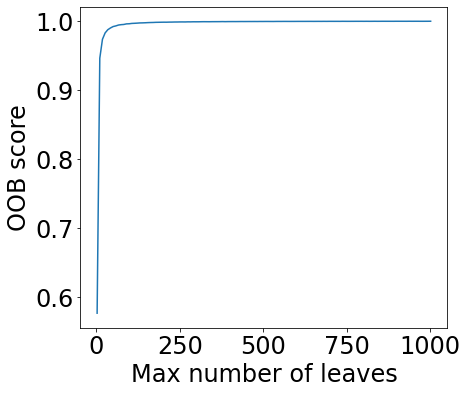

In [75]:

print('The number of leaves in the best estiamtor:', best_rnd_reg.max_leaf_nodes)
print('Best OBB Score: ', best_oob_score)

fig, ax = plt.subplots()
ax.plot(n_leaves_seq, rnd_oob_scores)
ax.set_xlabel('Max number of leaves')
ax.set_ylabel('OOB score');
fig.tight_layout()
plt.show()

The optimim number of leaves is 1002 with an OBB score of 0.99942. This score is slightly lower than the non-optimized score of the bagging of regression tree. One reason might be that the estimators for random forest are using a subset of regressors (sqrt of the total regressors). So the trees are built for 3 regressors out of the 6 regressors. As shown for simple regression tree, ln_loan_amnt was the most significant with low significance of other regressors. Building trees using these power features would reduce the overall quality of the model. Random forest is thus more suitable in case many features are used.

We can see the feature importance more clearly as follows.

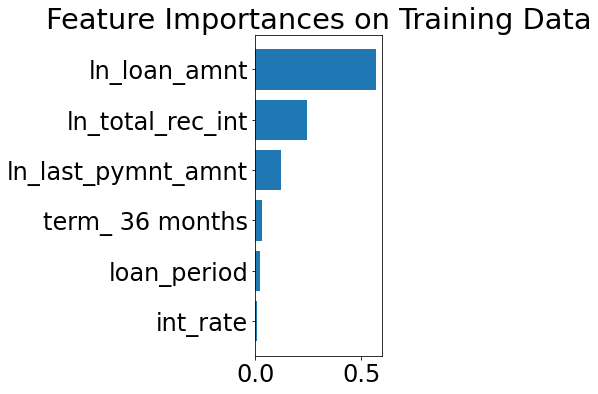

In [51]:
plot_features_importance(best_rnd_reg.feature_importances_, xColsNames)

As expected, other features are gaining more importance as they are used in estimators that excludes ln_loan_amnt. But random forest can help us see better the relative importance between other features. The least significant feature is int_rate. Initially, it was believed that int_rate should be an important factor in estimating the total_pymnt.

# 5. Boosting:

Boosting is another ensemble technique; however, unlike bagging, estimators aren't created independently but sequentially to reduce errors from ealrier estimators. Depending on the used loss function, it might be possible to get a closed form solution for the estimator parameters (Adaboost) or use a numerical approximation technique (Gradient Boosting). 
We work with boosting trees. Typically, trees of depth of 1 can be sufficient, and the only tuning parameter would be the number of estimators to avoid overfitting. However, depth 1 might sometimes result in poor results, so we perform cross validation on the tree depth first. We can then tune the number of estimators.  

## Adaboost
We use the exponential loss so Adaboost algorithm can be used as in sklearn [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).

In [17]:
max_depth_seq = np.arange(1, 30)
dtregs = [None] * max_depth_seq.size
for idx, depth in enumerate(max_depth_seq):
    dtregs[idx] = DecisionTreeRegressor(max_depth=depth)

ada_reg = AdaBoostRegressor(None, loss='exponential',
                            n_estimators=250, learning_rate=0.1)

kf = KFold(n_splits=10, shuffle=True, random_state=1)
gs_ada_reg_1 = GridSearchCV(ada_reg,
                            cv=kf,
                            param_grid={'base_estimator': dtregs},
                            scoring='neg_mean_squared_error',
                            n_jobs=-1, # Use all CPU cores
                            verbose=1,
                            return_train_score=True)
gs_ada_reg_1.fit(X_train, y_train);

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed: 31.0min finished


Optimal tree depth: 14
Lowest MSE: 3.533601467530167e-05


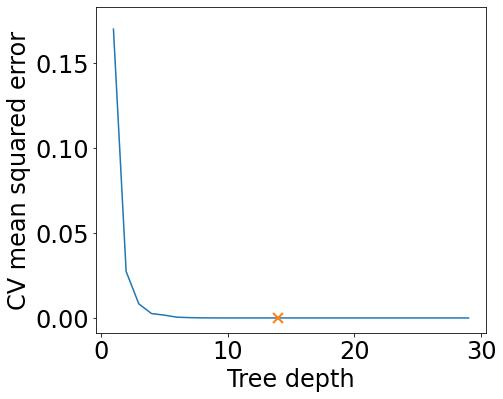

In [79]:
best_depth = max_depth_seq[gs_ada_reg_1.best_index_]
print('Optimal tree depth:', best_depth)
print('Lowest MSE:', -gs_ada_reg_1.best_score_)

x_axis_ticks = max_depth_seq
results = gs_ada_reg_1.cv_results_

fig, ax = plt.subplots()
ax.plot(x_axis_ticks, -results['mean_test_score'])
ax.plot(best_depth, -gs_ada_reg_1.best_score_,
        marker='x', markersize=10, mew=2)
ax.fill_between(x_axis_ticks,
                -results['mean_test_score'] - results['std_test_score'],
                -results['mean_test_score'] + results['std_test_score'],
                alpha=0.2)
ax.set_xlabel('Tree depth')
ax.set_ylabel('CV mean squared error');

An optimal tree depth of 14 was found with an MSE of 3.5e-5 which is an improvement over linear regression and bagging trees. 

Let's tune the number of estimators.

In [22]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=14),
                            loss='exponential',
                            learning_rate=0.1)

n_estimators_seq = np.arange(100, 1000, 50)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
gs_ada_reg_2 = GridSearchCV(ada_reg,
                            cv=kf,
                            param_grid={'n_estimators': n_estimators_seq},
                            scoring='neg_mean_squared_error',
                            n_jobs=-1, # Use all CPU cores
                            verbose=1,
                            return_train_score=True)
gs_ada_reg_2.fit(X_train, y_train);

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 49.4min finished


Optimal number of trees: 350
Lowest MSE: 3.5700060129786865e-05


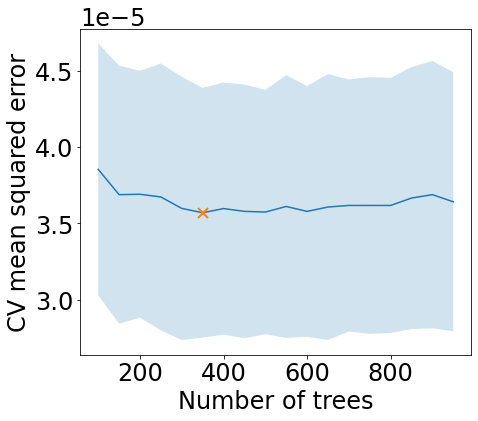

In [81]:
best_n_estimators = gs_ada_reg_2.best_params_['n_estimators']
print('Optimal number of trees:', best_n_estimators)
print('Lowest MSE:', -gs_ada_reg_2.best_score_)

plot_cv_results(gs_ada_reg_2, 'n_estimators', 'Number of trees')

The optimal number of estimators is 350 with a slight variation in MSE.  

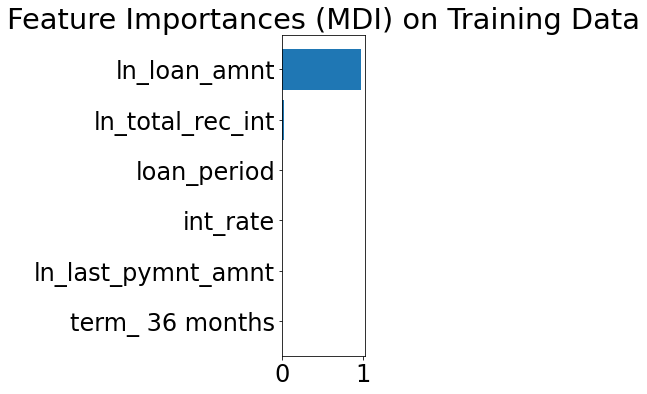

In [41]:
plot_features_importance(gs_ada_reg_2.best_estimator_.feature_importances_, xColsNames)

Again, since Adaboost was using the full set of regressors, ln_loan_amnt is the most significant feature.

## Gradient Boosting

If we choose to change the loss function to 'lad' (Least absolute deviations), we then need to move to gradient boosting. 

We used sklearn [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) with the same parameters from Adaboost (depth of 14, and 350 estimators). The max features were set to a sqrt of total features, so we expect a performance similiar to random forest.

In [82]:
# From Geron "Hands-On Machine Learning":
#   It is worth noting that an optimized implementation of Gradient Boosting is available
#   in the popular python library XGBoost, which stands for Extreme Gradient Boosting.
#   This package was initially developed by Tianqi Chen as part of the Distributed (Deep)
#   Machine Learning Community (DMLC), and it aims at being extremely fast, scalable
#   and portable. In fact, XGBoost is often an important component of the winning
#   entries in ML competitions. XGBoost's API is quite similar to Scikit-Learn's:

gb_reg = GradientBoostingRegressor(max_depth=14,
                                   n_estimators=350,
                                   loss='lad',
                                   max_features='sqrt',
                                   learning_rate=0.1)
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(loss='lad', max_depth=14, max_features='sqrt',
                          n_estimators=350)

In [90]:
gb_reg_train_mse = mean_squared_error(y_train, gb_reg.predict(X_train))
print('MSE: ', gb_reg_train_mse)

MSE:  3.637916069769188e-05


The obtained MSE is slightly lower than MSE for Adaboost. Given the different settings, it is expected that paramters needs to be tuned for gradient boosting independently. 

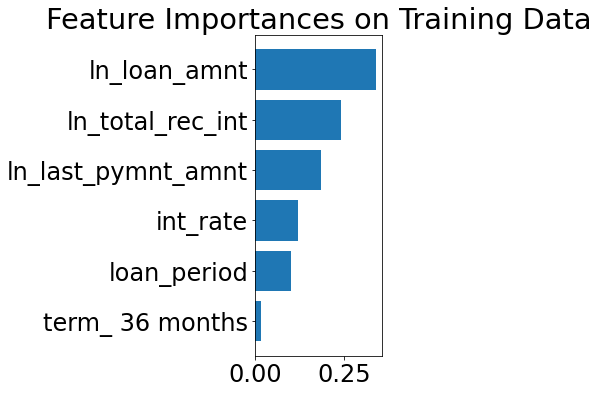

In [83]:
plot_features_importance(gb_reg.feature_importances_, xColsNames)

Similar to random forest, all features has some kind of significance since different estimators are using a subset of the features (sqrt). 

# 6. Models comparison:

We can now apply the test subset to compare the different models performance. 

### Linear model:

In [91]:
y_predicted_bestsubset = best_subset_linear.predict(X_test)
print("Best_Subset MSE: ",mean_squared_error(y_predicted_bestsubset,y_test))

Best_Subset MSE:  0.0007746468658632943


### Simple Decision Tree:

In [60]:
print('Optimum max_leaf_nodes: ', -gs_tree_reg_1.score(X_test, y_test))
print('Optimum ccp_alpha:', -gs_tree_reg_2.score(X_test, y_test))

Optimum max_leaf_nodes:  0.00013734479866193532
Optimum ccp_alpha: 0.0001407331467065532


### Random Forest:

In [77]:
rnd_reg_test_mse = mean_squared_error(y_test, best_rnd_reg.predict(X_test))
print('Random Forest: ', rnd_reg_test_mse)

Random Forest:  0.00026913585020524794


### Boosting:

In [85]:
print('Adaboost:', -gs_ada_reg_2.score(X_test, y_test))
gb_reg_test_mse = mean_squared_error(y_test, gb_reg.predict(X_test))
print('Gradient Boosting:', gb_reg_test_mse)

Adaboost: 4.4652984743371196e-05
Gradient Boosting: 0.0006582093964976869


In general, tree-based methods along with bagging and boosting can give better results than our benchmark linear regression.

Overall, Boosting can give the best results especially when the whole set of features is used. That's why Adaboost outperforms Gradient boosting in the above settings.

For the same reason, Random Forest has a lower performance that simple regression tree. Using the whole set of features could improve the random forest results. 
